# ************************************************************* #
#               Copyright (C) 2022 Jorge Brenes Alfaro.
#               EL5617 Trabajo Final de Graduación.
#               Escuela de Ingeniería Electrónica.
#               Tecnológico de Costa Rica.
# ************************************************************* #

This file is responsible for generating the mimetic neural network (MNN). First, the data collected from the PAHM is processed, which is reshaped as necessary for the network. Next, the model is developed using recurrent neural networks (RNN), specifically the GRU.

In [17]:
#Libraries to proccess data
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Libraries to create RNAM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import Dense, Dropout, GRU, TimeDistributed

import warnings
warnings.filterwarnings('ignore')

import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [4]:
wandb.init(project="Prueba", 
           entity="mimetic-rna", 
           name='Probando W&B 2',
           resume='Allow', 
           id='Probando W&B 2')
wandb.config = {
    "epochs": 500,
    "batch_size": 8,
    "learning_rate":0.001,
    "window": 100
}

 Process the Dataset 

In [36]:
Dir = os.listdir('/Users/jorge/Documents/TEC/TFG/Datos_Recolectados')

pwm = np.array([])
angle = np.array([])

# Read all the .csv files and make an nx4 array
# Next, separate the pwm value and angle in their respective arrays.
for filename in Dir:
    files = pd.read_csv('/Users/jorge/Documents/TEC/TFG/Datos_Recolectados/'+filename)
    pwm = np.append(pwm,np.zeros(100))
    pwm = np.append(pwm,files.values[:,2])
    angle = np.append(angle,np.zeros(100))
    angle = np.append(angle,files.values[:,3])

X_train = []
Y_train = []
window = 100

#For each element of training set, we have we have "window" previous training set elements 
for i in range(window,pwm.shape[0]):
    X_train.append(pwm[i-window:i])
    Y_train.append(angle[i])
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Separate the values in train, validation and test data/label
train_data, val_data, test_data = [],[],[]
train_label, val_label, test_label = [],[],[]

train_lenght = int(len(X_train)*3/5)
val_lenght = int(len(X_train)*4/5)

# Use 3/5 of the total data set for training 
# and 1/5 for validation and testing.

for i,j in zip(X_train[:train_lenght],Y_train[:train_lenght]):
    train_data.append(i)
    train_label.append(j)

for i,j in zip(X_train[train_lenght:val_lenght],Y_train[train_lenght:val_lenght]):
    val_data.append(i)
    val_label.append(j)
    
for i,j in zip(X_train[val_lenght:],Y_train[val_lenght:]):
    test_data.append(i)
    test_label.append(j)
    
train_data, val_data, test_data = np.array(train_data), np.array(val_data), np.array(test_data)
train_label, val_label, test_label = np.array(train_label), np.array(val_label), np.array(test_label)

tdata = test_data
tlabel = test_label

print('El total de datos de entrenamiento es: ', len(train_data), flush=True)
print('El total de datos de validación es: ', len(val_data), flush=True)
print('El total de datos de prueba es: ', len(test_data), flush=True)

# Reshape the arrays (n,window,1). Where n is the total amount of data in the array
train_data = np.reshape(train_data,(train_data.shape[0],train_data.shape[1],1))
val_data = np.reshape(val_data,(val_data.shape[0],val_data.shape[1],1))
test_data = np.reshape(test_data,(test_data.shape[0],test_data.shape[1],1))

El total de datos de entrenamiento es:  82911
El total de datos de validación es:  27637
El total de datos de prueba es:  27638


******************* Neural Network *******************
Model creation

In [6]:
clear_session()

model = Sequential()
model.add(GRU(64, input_shape=(X_train.shape[1],1),return_sequences=True))
model.add(Dropout(0.35))
model.add(GRU(64, input_shape=(X_train.shape[1],1),return_sequences=True))
model.add(Dropout(0.35))
model.add(TimeDistributed(Dense(1))) # There is no difference between this and model.add(Dense(1))...
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mse','acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100, 64)           12864     
_________________________________________________________________
dropout (Dropout)            (None, 100, 64)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100, 64)           24960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 64)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 1)            65        
Total params: 37,889
Trainable params: 37,889
Non-trainable params: 0
_________________________________________________________________


Model Training

In [7]:
history = model.fit(train_data, train_label,
                    epochs=10, batch_size=8,
                    validation_data = (val_data,val_label),
                    verbose=2,callbacks=[WandbCallback(save_model=False)])
# Prediction
testPredict = model.predict(test_data)

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Epoch 1/10
10364/10364 - 728s - loss: 294.8165 - mse: 294.8165 - acc: 0.0346 - val_loss: 146.5870 - val_mse: 146.5870 - val_acc: 5.4275e-06
Epoch 2/10
10364/10364 - 685s - loss: 216.8193 - mse: 216.8193 - acc: 0.0544 - val_loss: 135.2886 - val_mse: 135.2886 - val_acc: 0.0882
Epoch 3/10
10364/10364 - 704s - loss: 198.2744 - mse: 198.2744 - acc: 0.0533 - val_loss: 124.9928 - val_mse: 124.9928 - val_acc: 0.0575
Epoch 4/10
10364/10364 - 706s - loss: 189.7564 - mse: 189.7564 - acc: 0.0528 - val_loss: 119.5809 - val_mse: 119.5809 - val_acc: 0.0373
Epoch 5/10
10364/10364 - 705s - loss: 183.1553 - mse: 183.1553 - acc: 0.0516 - val_loss: 119.0934 - val_mse: 119.0934 - val_acc: 0.0283
Epoch 6/10
10364/10364 - 702s - loss: 177.7654 - mse: 177.7654 - acc: 0.0509 - val_loss: 122.1537 - val_mse: 122.1537 - val_acc: 0.0975
Epoch 7/10
10364/10364 - 707s - loss: 172.6065 - mse: 172.6065 - acc: 0.0500 - val_loss: 11

Model Evaluate

In [24]:
test_data.shape

(27638, 100, 1)

In [8]:
loss, accuracy = model.evaluate(test_data,test_label)

864/864 [==============================] - 11s 13ms/step - loss: 40.0977 - mse: 40.0977 - acc: 0.0217


ValueError: too many values to unpack (expected 2)

In [14]:
joblib.dump(model, 'GRU_model.joblib')

TypeError: cannot pickle 'weakref' object

Plot the predicted and "true" output and plot training and validation losses

In [40]:
test_Predicted = np.reshape(testPredict,(np.size(testPredict)))
tlabel.shape


(27638,)

In [27]:
testPredict.shape
test_Predicted = tf.reshape(testPredict,[np.size(testPredict)])
test_Predicted.shape


TensorShape([2763800])

In [37]:
tdata

array([[0.069, 0.069, 0.069, ..., 0.11 , 0.11 , 0.11 ],
       [0.069, 0.069, 0.069, ..., 0.11 , 0.11 , 0.11 ],
       [0.069, 0.069, 0.069, ..., 0.11 , 0.11 , 0.11 ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]])

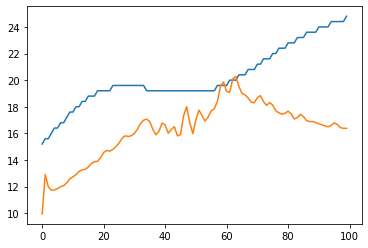

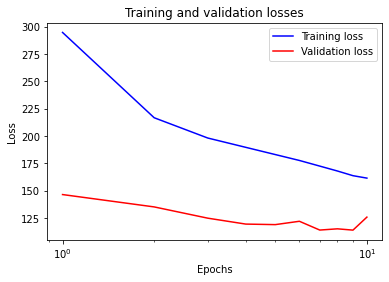

In [48]:
#TEngo que graficar real vs predicha
plt.figure()
plt.plot(tlabel[0:100])
plt.plot(testPredict[1])

loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.figure()
plt.plot(epochs, loss,'b', label='Training loss')
plt.plot(epochs, val_loss,'r', label='Validation loss')
plt.title('Training and validation losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xscale('log')
plt.legend()
plt.show()